# 探索攻击者数量对实验结果的影响 但是截断操作依旧是移除最大的6个和最小的6个

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

# DRA算法+无拜占庭攻击

In [ ]:
#定义变量 
agent_resource_quantity = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true= [] #100个agent的平均资源量
x_average_resource_quantity=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v=0.146#v-强凸参数 
iteration_update = 0.620#迭代步长
beta= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
dual_variable = np.zeros(shape=(100,1000))#对偶变量
W=np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt") #双随机的网络拓扑矩阵W（对角线处非零）
sum = 0 #过渡变量
iteration=[]#绘图横坐标
average_cost=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
x_average=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化

for i in range (0,100):
    if i<10:
        agent_resource_quantity[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity[i][0]=10
    
for i in range (0,100):
    if i==74:
        agent_resource_quantity[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity[i][0]=agent_resource_quantity[i][0]
    
#资源量真实均值的计算 初始值
sum1=0
for i in range (0,100):
    sum1 = sum1 + agent_resource_quantity[i][0] 
average_resource_quantity_true.append(sum1/100)

#平均追踪值x的平均值 初始值
sum2=0
for i in range (0,100):
    sum2 = sum2 + x_average_resource_quantity[i][0] 
x_average.append(sum2/100)

#平均成本 初始值
sum_average_cost=0
for j in range(0,100):
    sum_average_cost=sum_average_cost+(-beta[j]*300*math.log(1+agent_resource_quantity[j][0]))
average_cost[0][0]=sum_average_cost/100 
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable[i][0]=1

iteration.append(0)


In [ ]:
#FODAC-PD-DRA算法 
def FODAC_PD_DRA(beta,agent_resource_quantity,average_resource_quantity_true,x_average_resource_quantity,v,iteration_update,dual_variable,W,iteration):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+无拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1 = 0
        sum2 = 0
        sum_average_cost=0
        iteration.append(k)
        
        #用户资源申请量的迭代
        for i in range (0,100):
            agent_resource_quantity[i][k]=(agent_resource_quantity[i][k-1]-iteration_update
            *((-beta[i]*300)/100*(1/(1+agent_resource_quantity[i][k-1]))+(dual_variable[i][k-1]/100)
              +(v*agent_resource_quantity[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity[i][k] < 0:
                agent_resource_quantity[i][k]=0
            elif agent_resource_quantity[i][k] > 10: 
                agent_resource_quantity[i][k]=10
                
        #平均值追踪量的迭代 最新版 Wx+资源量差值
        for i in range (0,100):
            sum_x=0
            for j in range (0,100):
                if W[i][j]!=0:
                    sum_x=sum_x+W[i][j]*x_average_resource_quantity[j][k-1]
            x_average_resource_quantity[i][k]=sum_x+(agent_resource_quantity[i][k]-agent_resource_quantity[i][k-1])        
        
        #对偶变量的迭代
        for i in range(0,100):
            dual_variable[i][k]=(dual_variable[i][k-1]+iteration_update
            *((x_average_resource_quantity[i][k-1])-(5)-(v*dual_variable[i][k-1])))
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable[i][k] <0:
                dual_variable[i][k] =0    
        
        #计算真实的平均资源
        for i in range (0,100):
            sum1 = sum1 + agent_resource_quantity[i][k]
        average_resource_quantity_true.append(sum1/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2 = sum2 + x_average_resource_quantity[i][k]
        x_average.append(sum2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost=sum_average_cost+(-beta[j]*300*math.log(1+agent_resource_quantity[j][k]))
        average_cost[0][k]=sum_average_cost/100    
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable[i][k])       
        print("****************************************************************************")
    
    return None

In [ ]:
FODAC_PD_DRA(beta,agent_resource_quantity,average_resource_quantity_true,x_average_resource_quantity,v,iteration_update,dual_variable,W,iteration)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity.txt',agent_resource_quantity,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost.txt',average_cost,fmt='%0.8f')#用户平均成本
np.savetxt('./data/03_average_resource_quantity_true.txt',average_resource_quantity_true,fmt='%0.8f')#用户真实平均资源

# DRA算法+极大值攻击 6个攻击者

攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack1 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack1= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack1=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack1=0.146#v-强凸参数 
iteration_update_attack1 = 0.62
dual_variable_attack1 = np.zeros(shape=(100,1000))#对偶变量
beta_attack1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack1 = 0.06 #100个用户中拜占庭用户的比例 100*proportion_attack1=拜占庭用户数量
W_attack1 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack1 = 0 #过渡变量
iteration_attack1=[]#绘图横坐标
average_cost_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有诚实用户成本的平均值
average_honest_resource_quantity_attack1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化

for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack1[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack1[94][0]=10
agent_resource_quantity_attack1[95][0]=10
agent_resource_quantity_attack1[96][0]=10
agent_resource_quantity_attack1[97][0]=10
agent_resource_quantity_attack1[98][0]=10
agent_resource_quantity_attack1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack1[i][0]=agent_resource_quantity_attack1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack1=0
for i in range (0,100):
    sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][0] 
average_resource_quantity_true_attack1.append(sum1_attack1/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack1=0
for i in range (0,100):
    sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][0] 
x_average_attack1.append(sum2_attack1/100)

#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack1[i][0]=1

iteration_attack1.append(0)

#平均成本 初始值
sum_average_cost_attack1=0
for j in range(0,100):
    sum_average_cost_attack1=(sum_average_cost_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_attack1[0][0]=sum_average_cost_attack1/100

#计算诚实用户的平均成本 初始值 
sum_average_cost_honest_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_honest_attack1[0][0]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))

#诚实用户的平均资源量
sum_honest_resource_quantity_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][0]
average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))


In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack1)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack1 = 0
        sum2_attack1 = 0
        sum_average_cost_attack1=0
        sum_average_cost_honest_attack1=0
        iteration_attack1.append(k)
        sum_honest_resource_quantity_attack1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack1*100)):
            agent_resource_quantity_attack1[i][k]=(agent_resource_quantity_attack1[i][k-1]
            -iteration_update_attack1*((-beta_attack1[i]*300)/100*(1/(1+agent_resource_quantity_attack1[i][k-1]))
              +(dual_variable_attack1[i][k-1]/100)+(v_attack1*agent_resource_quantity_attack1[i][k-1])) )            
            #原变量的投影操作
            if agent_resource_quantity_attack1[i][k] < 0:
                agent_resource_quantity_attack1[i][k]=0
            elif agent_resource_quantity_attack1[i][k] > 10: 
                agent_resource_quantity_attack1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_attack1*100)),100):
            agent_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100):
            sum_x_attack1=0
            for j in range (0,100):
                if W_attack1[i][j]!=0:
                    sum_x_attack1=sum_x_attack1+W_attack1[i][j]*x_average_resource_quantity_attack1[j][k-1]
            x_average_resource_quantity_attack1[i][k]=sum_x_attack1+(agent_resource_quantity_attack1[i][k]-agent_resource_quantity_attack1[i][k-1])                     
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack1*100)),100):
            x_average_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1] 
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack1*100)):
            dual_variable_attack1[i][k]=(dual_variable_attack1[i][k-1]+iteration_update_attack1
            *((x_average_resource_quantity_attack1[i][k-1])-(5)-(v_attack1*dual_variable_attack1[i][k-1])))
            
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack1*100)),100):
            dual_variable_attack1[i][k]=dual_variable_attack1[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100-int(proportion_attack1*100)):
            if dual_variable_attack1[i][k] < 0:
                dual_variable_attack1[i][k] =0 
                
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][k]
        average_resource_quantity_true_attack1.append(sum1_attack1/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][k]
        x_average_attack1.append(sum2_attack1/100)
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_attack1=(sum_average_cost_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_attack1[0][k]=sum_average_cost_attack1/100 

        #计算诚实用户的平均成本 
        for j in range(0,100-int(proportion_attack1*100)):
            sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_honest_attack1[0][k]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack1*100)):
            sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][k]        
        average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack1[i][k])       
        print("****************************************************************************")
    
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack1_6B.txt',agent_resource_quantity_attack1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack1_6B.txt',average_cost_honest_attack1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack1_6B.txt',average_honest_resource_quantity_attack1,fmt='%0.8f')#诚实用户平均资源

# DRA算法+截断式高斯攻击 6个攻击者
攻击方式：被攻击的agent在每次迭代中有随机的恶意资源申请量（不进行更新），并将该随机恶意资源量发送给邻居

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack2 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack2= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack2=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack2=0.146#v-强凸参数 
iteration_update_attack2 =0.62
dual_variable_attack2 = np.zeros(shape=(100,1000))#对偶变量
beta_attack2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack2 = 0.06 #被攻击的用户比例 
W_attack2 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack2 = 0 #过渡变量
iteration_attack2 = []
random_attack=np.zeros(shape=(6,1000))#记录n=6个攻击者的攻击资源量
average_cost_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_attack2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:

#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack2[94][0]=0
agent_resource_quantity_attack2[95][0]=0
agent_resource_quantity_attack2[96][0]=0
agent_resource_quantity_attack2[97][0]=0
agent_resource_quantity_attack2[98][0]=0
agent_resource_quantity_attack2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack2[i][0]=agent_resource_quantity_attack2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack2=0
for i in range (0,100):
    sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][0] 
average_resource_quantity_true_attack2.append(sum1_attack2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack2=0
for i in range (0,100):
    sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][0] 
x_average_attack2.append(sum2_attack2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack2[i][0]=1

iteration_attack2.append(0)

#平均成本 初始值
sum_average_cost_attack2=0
for j in range(0,100):
    sum_average_cost_attack2=(sum_average_cost_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_attack2[0][0]=sum_average_cost_attack2/100 

#计算所有诚实用户的平均成本 初始值
sum_average_cost_honest_attack2=0
for j in range(0,100-int((proportion_attack2*100))):
    sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_honest_attack2[0][0]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))

random_attack[0][0]=0
random_attack[1][0]=0
random_attack[2][0]=0
random_attack[3][0]=0
random_attack[4][0]=0
random_attack[5][0]=0

sum_honest_resource_quantity_attack2=0
for j in range(0,100-int(proportion_attack2*100)):
    sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][0]
average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))

In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中有随机的恶意资源申请量（不进行更新），并将该随机恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack2 = 0
        sum2_attack2 = 0
        sum_average_cost_attack2=0
        iteration_attack2.append(k)
        sum_average_cost_honest_attack2=0
        sum_honest_resource_quantity_attack2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack2*100)):
            agent_resource_quantity_attack2[i][k]=(agent_resource_quantity_attack2[i][k-1]-iteration_update_attack2
            *((-beta_attack2[i]*300)/100*(1/(1+agent_resource_quantity_attack2[i][k-1]))+(dual_variable_attack2[i][k-1]/100)
              +(v_attack2*agent_resource_quantity_attack2[i][k-1])) )
             #原变量的投影操作
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10:
                agent_resource_quantity_attack2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int(proportion_attack2*100),100):
            agent_resource_quantity_attack2[i][k]=np.random.normal(7, 3, 1) #服从高斯分布的攻击
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10: #原变量的投影操作
                agent_resource_quantity_attack2[i][k]=10
            random_attack[i-94][k]=agent_resource_quantity_attack2[i][k]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100):
            sum_x_attack2=0
            for j in range (0,100):
                if W_attack2[i][j]!=0:
                    sum_x_attack2=sum_x_attack2+W_attack2[i][j]*x_average_resource_quantity_attack2[j][k-1]
            x_average_resource_quantity_attack2[i][k]=sum_x_attack2+(agent_resource_quantity_attack2[i][k]-agent_resource_quantity_attack2[i][k-1])  
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack2*100)),100):
            x_average_resource_quantity_attack2[i][k]=agent_resource_quantity_attack2[i][k] #被攻击的用户不进行x的更新，直接取与资源申请量相同的随机值
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack2*100)):
            dual_variable_attack2[i][k]=(dual_variable_attack2[i][k-1]+iteration_update_attack2
            *((x_average_resource_quantity_attack2[i][k-1])-(5)-(v_attack2*dual_variable_attack2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack2*100)),100):
            dual_variable_attack2[i][k]=dual_variable_attack2[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_attack2[i][k] < 0:
                dual_variable_attack2[i][k] =0   
                
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][k]
        average_resource_quantity_true_attack2.append(sum1_attack2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][k]
        x_average_attack2.append(sum2_attack2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_attack2=(sum_average_cost_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_attack2[0][k]=sum_average_cost_attack2/100 
        
        #计算所有诚实用户的平均成本
        for j in range(0,100-int((proportion_attack2*100))):
            sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_honest_attack2[0][k]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack2*100)):
            sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][k]        
        average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack2[i][k])       
        print("****************************************************************************")
  
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack2_6B.txt',agent_resource_quantity_attack2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack2_6B.txt',average_cost_honest_attack2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack2_6B.txt',average_honest_resource_quantity_attack2,fmt='%0.8f')#诚实用户平均资源

# BREDA算法 +极大值攻击 6个攻击者
静态攻击（确定性攻击）+trimmed mean
考虑100个用户中有6个拜占庭用户（用户通信的拓扑结构中每个用户的度为15）

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust1 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust1= [] 
x_average_resource_quantity_robust1=np.zeros(shape=(100,1000))
v_robust1=0.146
iteration_update_robust1 = 0.62
dual_variable_robust1 = np.zeros(shape=(100,1000))
beta_robust1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust1 = 0.06 
A_robust1 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust1_help=[]
sum_robust1 = 0 
iteration_robust1 = []
average_cost_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust1[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_robust1[94][0]=10
agent_resource_quantity_robust1[95][0]=10
agent_resource_quantity_robust1[96][0]=10
agent_resource_quantity_robust1[97][0]=10
agent_resource_quantity_robust1[98][0]=10
agent_resource_quantity_robust1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=2.0
        
        
for i in range (0,100):
    x_average_resource_quantity_robust1[i][0]=agent_resource_quantity_robust1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust1=0
for i in range (0,100):
    sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][0] 
average_resource_quantity_true_robust1.append(sum1_robust1/100)

#所有诚实用户平均追踪值x的平均值 初始值
sum2_robust1=0
for i in range (0,100-int((proportion_robust1*100))):
    sum2_robust1 = sum2_robust1 + x_average_resource_quantity_robust1[i][0] 
x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))

#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust1[i][0]=1

iteration_robust1.append(0)

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust1[i][j]!=0:
            neighbor_robust1_help.append(j)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(100,15)

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust1=0
for j in range(0,100-int((proportion_robust1*100))):
    sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_honest_robust1[0][0]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100))) 

#计算所有用户平均成本 初始值
sum_average_cost_robust1=0
for j in range(0,100):
    sum_average_cost_robust1=(sum_average_cost_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_robust1[0][0]=sum_average_cost_robust1/100


#诚实用户的平均资源量  
sum_honest_resource_quantity_robust1=0
for j in range(0,100-int(proportion_robust1*100)):
    sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][0]
average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))

#定义gap变量来记录诚实用户资源初始值和平均资源初始值之间的差距 二范数的平方
gap=0
for i in range (0,100-int(proportion_robust1*100)):
    gap=gap+((average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0])*(average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0]))


In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    print("诚实用户的资源初始值和平均资源初始值间的gap:",gap )
    print("****************************************************************************************************")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust1)
    print("****************************************************************************************************")
    print("被攻击的用户数量为:",int(proportion_robust1*100))
    print("****************************************************************************")
    print("诚实用户的平均资源的初始值为:",average_honest_resource_quantity_robust1[0])
    print("****************************************************************************")
    print("诚实用户追踪平均资源均值的平均值初始值为:",x_average_robust1[0] ) 
    print("****************************************************************************")
    
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust1 = 0
        sum2_robust1 = 0
        iteration_robust1.append(k)
        sum_average_cost_robust1=0
        sum_average_cost_honest_robust1=0
        sum_honest_resource_quantity_robust1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust1*100)):
            
            agent_resource_quantity_robust1[i][k]=(agent_resource_quantity_robust1[i][k-1]-iteration_update_robust1
            *((-beta_robust1[i]*300)/100*(1/(1+agent_resource_quantity_robust1[i][k-1]))+(dual_variable_robust1[i][k-1]/100)
              +(v_robust1*agent_resource_quantity_robust1[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust1[i][k] < 0:
                agent_resource_quantity_robust1[i][k]=0
            elif agent_resource_quantity_robust1[i][k] > 10: 
                agent_resource_quantity_arobust1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust1*100)),100):
            agent_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k-1]
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust1*100)):
            sort_list_robust1=[]
            sum_x_robust1=0
            for j in range (0,15):
                sort_list_robust1.append(x_average_resource_quantity_robust1[neighbor_robust1[i,j]][k-1])
            sort_list_robust1.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,(int(proportion_robust1*100))):
                del sort_list_robust1[14-j]
            for j in range(0,(int(proportion_robust1*100))):
                del sort_list_robust1[0]     
            for j in range(0,len(sort_list_robust1)):
                sum_x_robust1=sum_x_robust1+sort_list_robust1[j]
            
            x_average_resource_quantity_robust1[i][k]=((1/4)*(x_average_resource_quantity_robust1[i][k-1]+sum_x_robust1)
            +(agent_resource_quantity_robust1[i][k]-agent_resource_quantity_robust1[i][k-1]) )
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust1*100)),100):
            x_average_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust1*100)):
            dual_variable_robust1[i][k]=(dual_variable_robust1[i][k-1]+iteration_update_robust1
            *((x_average_resource_quantity_robust1[i][k-1])-(5)-(v_robust1*dual_variable_robust1[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust1*100)),100):
            dual_variable_robust1[i][k]=dual_variable_robust1[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust1[i][k] < 0:
                dual_variable_robust1[i][k] =0    
        
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][k]
        average_resource_quantity_true_robust1.append(sum1_robust1/100)
        
        #计算诚实用户的平均资源追踪值x的平均值
        for i in range (0,100-int((proportion_robust1*100))):
            sum2_robust1= sum2_robust1 + x_average_resource_quantity_robust1[i][k]
        x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_robust1=(sum_average_cost_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_robust1[0][k]=sum_average_cost_robust1/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust1*100))):
            sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_honest_robust1[0][k]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100)))       
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust1*100)):
            sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][k]        
        average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust1[i][k])   
        print("在",k,"次迭代中的诚实用户的平均资源为:",average_honest_resource_quantity_robust1[k])
        print("在",k,"次迭代中的诚实用户追踪平均资源均值的平均值为:",x_average_robust1[k] )                 
        print("****************************************************************************")
        
    #结束迭代后，计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方
    gap1=0
    for i in range (0,100-int(proportion_robust1*100)):
        gap1=gap1+((x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999])*(x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999]))
    print("*******************************************************************************************")
    print("计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方:",gap1 )
    
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust1_6B.txt',agent_resource_quantity_robust1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust1_6B.txt',average_cost_honest_robust1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust1_6B.txt',average_honest_resource_quantity_robust1,fmt='%0.8f')#诚实用户平均资源

# BREDA算法+截断式高斯攻击 6个攻击者
静态攻击（随机性攻击）+trimmed mean
考虑100个用户中有6个拜占庭用户（用户通信的拓扑结构中每个用户的度为15）

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust2 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust2= [] 
x_average_resource_quantity_robust2=np.zeros(shape=(100,1000))
v_robust2=0.146
iteration_update_robust2 = 0.62
dual_variable_robust2 = np.zeros(shape=(100,1000))
beta_robust2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust2 = 0.06 
A_robust2 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust2_help=[]
sum_robust2 = 0 
iteration_robust2 = []
average_cost_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
#对应到论文中的t=0时的资源量
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_robust2[94][0]=0
agent_resource_quantity_robust2[95][0]=0
agent_resource_quantity_robust2[96][0]=0
agent_resource_quantity_robust2[97][0]=0
agent_resource_quantity_robust2[98][0]=0
agent_resource_quantity_robust2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=2.0
        
for i in range (0,100):
    x_average_resource_quantity_robust2[i][0]=agent_resource_quantity_robust2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust2=0
for i in range (0,100):
    sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][0] 
average_resource_quantity_true_robust2.append(sum1_robust2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_robust2=0
for i in range (0,100):
    sum2_robust2 = sum2_robust2 + x_average_resource_quantity_robust2[i][0] 
x_average_robust2.append(sum2_robust2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust2[i][0]=1

iteration_robust2.append(0)

#计算所有用户的平均成本 初始值
sum_average_cost_robust2=0
for j in range(0,100):
    sum_average_cost_robust2=(sum_average_cost_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))      
average_cost_robust2[0][0]=sum_average_cost_robust2/100

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust2=0
for j in range(0,100-int((proportion_robust2*100))):
    sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))        
average_cost_honest_robust2[0][0]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust2[i][j]!=0:
            neighbor_robust2_help.append(j)
neighbor_robust2=np.array(neighbor_robust2_help).reshape(100,15)

sum_honest_resource_quantity_robust2=0
for j in range(0,100-int(proportion_robust2*100)):
    sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][0]
average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))

In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean2算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中选择随机的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust2 = 0
        sum2_robust2 = 0
        iteration_robust2.append(k)
        sum_average_cost_robust2=0
        sum_average_cost_honest_robust2=0
        sum_honest_resource_quantity_robust2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust2*100)):
            agent_resource_quantity_robust2[i][k]=(agent_resource_quantity_robust2[i][k-1]-iteration_update_robust2
            *((-beta_robust2[i]*300)/100*(1/(1+agent_resource_quantity_robust2[i][k-1]))+(dual_variable_robust2[i][k-1]/100)
              +(v_robust2*agent_resource_quantity_robust2[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust2[i][k] < 0:
                agent_resource_quantity_robust2[i][k]=0
            elif agent_resource_quantity_robust2[i][k] > 10: 
                agent_resource_quantity_arobust2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust2*100)),100):
            agent_resource_quantity_robust2[i][k]=random_attack[i-94][k] #被攻击的用户的资源量取随机值
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust2*100)):
            sort_list_robust2=[]
            sum_x_robust2=0
            for j in range (0,15):
                sort_list_robust2.append(x_average_resource_quantity_robust2[neighbor_robust2[i,j]][k-1])
            sort_list_robust2.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,int(proportion_robust2*100)):
                del sort_list_robust2[14-j]
            for j in range(0,int(proportion_robust2*100)):
                del sort_list_robust2[0]            
            for j in range(0,len(sort_list_robust2)):
                sum_x_robust2=sum_x_robust2+(sort_list_robust2[j])
            
            x_average_resource_quantity_robust2[i][k]=((1/4)*(x_average_resource_quantity_robust2[i][k-1]+sum_x_robust2)
            +(agent_resource_quantity_robust2[i][k]-agent_resource_quantity_robust2[i][k-1]) )
        
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust2*100)),100):
            x_average_resource_quantity_robust2[i][k]=agent_resource_quantity_robust2[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust2*100)):
            dual_variable_robust2[i][k]=(dual_variable_robust2[i][k-1]+iteration_update_robust2
            *((x_average_resource_quantity_robust2[i][k-1])-(5)-(v_robust2*dual_variable_robust2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust2*100)),100):
            dual_variable_robust2[i][k]=dual_variable_robust2[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust2[i][k] < 0:
                dual_variable_robust2[i][k] =0    
        
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][k]
        average_resource_quantity_true_robust2.append(sum1_robust2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_robust2= sum2_robust2 + x_average_resource_quantity_robust2[i][k]
        x_average_robust2.append(sum2_robust2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_robust2=(sum_average_cost_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))      
        average_cost_robust2[0][k]=sum_average_cost_robust2/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust2*100))):
            sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))        
        average_cost_honest_robust2[0][k]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust2*100)):
            sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][k]        
        average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust2[i][k])       
        print("****************************************************************************")
        
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust2_6B.txt',agent_resource_quantity_robust2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust2_6B.txt',average_cost_honest_robust2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust2_6B.txt',average_honest_resource_quantity_robust2,fmt='%0.8f')#诚实用户平均资源

# DRA算法+极大值攻击 3个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack1 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack1= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack1=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack1=0.146#v-强凸参数 
iteration_update_attack1 = 0.62
dual_variable_attack1 = np.zeros(shape=(100,1000))#对偶变量
beta_attack1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack1 = 0.03 #100个用户中拜占庭用户的比例 100*proportion_attack1=拜占庭用户数量
W_attack1 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack1 = 0 #过渡变量
iteration_attack1=[]#绘图横坐标
average_cost_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有诚实用户成本的平均值
average_honest_resource_quantity_attack1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化

for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack1[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack1[97][0]=10
agent_resource_quantity_attack1[98][0]=10
agent_resource_quantity_attack1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack1[i][0]=agent_resource_quantity_attack1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack1=0
for i in range (0,100):
    sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][0] 
average_resource_quantity_true_attack1.append(sum1_attack1/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack1=0
for i in range (0,100):
    sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][0] 
x_average_attack1.append(sum2_attack1/100)

#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack1[i][0]=1

iteration_attack1.append(0)

#平均成本 初始值
sum_average_cost_attack1=0
for j in range(0,100):
    sum_average_cost_attack1=(sum_average_cost_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_attack1[0][0]=sum_average_cost_attack1/100

#计算诚实用户的平均成本 初始值 
sum_average_cost_honest_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_honest_attack1[0][0]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))

#诚实用户的平均资源量
sum_honest_resource_quantity_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][0]
average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))


In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack1)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack1 = 0
        sum2_attack1 = 0
        sum_average_cost_attack1=0
        sum_average_cost_honest_attack1=0
        iteration_attack1.append(k)
        sum_honest_resource_quantity_attack1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack1*100)):
            agent_resource_quantity_attack1[i][k]=(agent_resource_quantity_attack1[i][k-1]
            -iteration_update_attack1*((-beta_attack1[i]*300)/100*(1/(1+agent_resource_quantity_attack1[i][k-1]))
              +(dual_variable_attack1[i][k-1]/100)+(v_attack1*agent_resource_quantity_attack1[i][k-1])) )            
            #原变量的投影操作
            if agent_resource_quantity_attack1[i][k] < 0:
                agent_resource_quantity_attack1[i][k]=0
            elif agent_resource_quantity_attack1[i][k] > 10: 
                agent_resource_quantity_attack1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_attack1*100)),100):
            agent_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100-int(proportion_attack1*100)):
            sum_x_attack1=0
            for j in range (0,100):
                if W_attack1[i][j]!=0:
                    sum_x_attack1=sum_x_attack1+W_attack1[i][j]*x_average_resource_quantity_attack1[j][k-1]
            x_average_resource_quantity_attack1[i][k]=sum_x_attack1+(agent_resource_quantity_attack1[i][k]-agent_resource_quantity_attack1[i][k-1])                     
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack1*100)),100):
            x_average_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1] 
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack1*100)):
            dual_variable_attack1[i][k]=(dual_variable_attack1[i][k-1]+iteration_update_attack1
            *((x_average_resource_quantity_attack1[i][k-1])-(5)-(v_attack1*dual_variable_attack1[i][k-1])))
            
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack1*100)),100):
            dual_variable_attack1[i][k]=dual_variable_attack1[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100-int(proportion_attack1*100)):
            if dual_variable_attack1[i][k] < 0:
                dual_variable_attack1[i][k] =0 
                
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][k]
        average_resource_quantity_true_attack1.append(sum1_attack1/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][k]
        x_average_attack1.append(sum2_attack1/100)
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_attack1=(sum_average_cost_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_attack1[0][k]=sum_average_cost_attack1/100 

        #计算诚实用户的平均成本 
        for j in range(0,100-int(proportion_attack1*100)):
            sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_honest_attack1[0][k]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack1*100)):
            sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][k]        
        average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack1[i][k])       
        print("****************************************************************************")
    
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack1_3B.txt',agent_resource_quantity_attack1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack1_3B.txt',average_cost_honest_attack1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack1_3B.txt',average_honest_resource_quantity_attack1,fmt='%0.8f')#诚实用户平均资源

# DRA算法+截断式高斯攻击 3个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack2 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack2= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack2=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack2=0.146#v-强凸参数 
iteration_update_attack2 =0.62
dual_variable_attack2 = np.zeros(shape=(100,1000))#对偶变量
beta_attack2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack2 = 0.03 #被攻击的用户比例 
W_attack2 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack2 = 0 #过渡变量
iteration_attack2 = []
random_attack=np.zeros(shape=(3,1000))#记录n=3个攻击者的攻击资源量
average_cost_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_attack2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:

#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack2[97][0]=0
agent_resource_quantity_attack2[98][0]=0
agent_resource_quantity_attack2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack2[i][0]=agent_resource_quantity_attack2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack2=0
for i in range (0,100):
    sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][0] 
average_resource_quantity_true_attack2.append(sum1_attack2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack2=0
for i in range (0,100):
    sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][0] 
x_average_attack2.append(sum2_attack2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack2[i][0]=1

iteration_attack2.append(0)

#平均成本 初始值
sum_average_cost_attack2=0
for j in range(0,100):
    sum_average_cost_attack2=(sum_average_cost_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_attack2[0][0]=sum_average_cost_attack2/100 

#计算所有诚实用户的平均成本 初始值
sum_average_cost_honest_attack2=0
for j in range(0,100-int((proportion_attack2*100))):
    sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_honest_attack2[0][0]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))

random_attack[0][0]=0
random_attack[1][0]=0
random_attack[2][0]=0


sum_honest_resource_quantity_attack2=0
for j in range(0,100-int(proportion_attack2*100)):
    sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][0]
average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))

In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中有随机的恶意资源申请量（不进行更新），并将该随机恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack2 = 0
        sum2_attack2 = 0
        sum_average_cost_attack2=0
        iteration_attack2.append(k)
        sum_average_cost_honest_attack2=0
        sum_honest_resource_quantity_attack2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack2*100)):
            agent_resource_quantity_attack2[i][k]=(agent_resource_quantity_attack2[i][k-1]-iteration_update_attack2
            *((-beta_attack2[i]*300)/100*(1/(1+agent_resource_quantity_attack2[i][k-1]))+(dual_variable_attack2[i][k-1]/100)
              +(v_attack2*agent_resource_quantity_attack2[i][k-1])) )
             #原变量的投影操作
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10:
                agent_resource_quantity_attack2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int(proportion_attack2*100),100):
            agent_resource_quantity_attack2[i][k]=np.random.normal(7, 3, 1) #服从高斯分布的攻击
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10: #原变量的投影操作
                agent_resource_quantity_attack2[i][k]=10
            random_attack[i-97][k]=agent_resource_quantity_attack2[i][k]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100):
            sum_x_attack2=0
            for j in range (0,100):
                if W_attack2[i][j]!=0:
                    sum_x_attack2=sum_x_attack2+W_attack2[i][j]*x_average_resource_quantity_attack2[j][k-1]
            x_average_resource_quantity_attack2[i][k]=sum_x_attack2+(agent_resource_quantity_attack2[i][k]-agent_resource_quantity_attack2[i][k-1])  
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack2*100)),100):
            x_average_resource_quantity_attack2[i][k]=agent_resource_quantity_attack2[i][k] #被攻击的用户不进行x的更新，直接取与资源申请量相同的随机值
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack2*100)):
            dual_variable_attack2[i][k]=(dual_variable_attack2[i][k-1]+iteration_update_attack2
            *((x_average_resource_quantity_attack2[i][k-1])-(5)-(v_attack2*dual_variable_attack2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack2*100)),100):
            dual_variable_attack2[i][k]=dual_variable_attack2[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_attack2[i][k] < 0:
                dual_variable_attack2[i][k] =0   
                
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][k]
        average_resource_quantity_true_attack2.append(sum1_attack2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][k]
        x_average_attack2.append(sum2_attack2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_attack2=(sum_average_cost_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_attack2[0][k]=sum_average_cost_attack2/100 
        
        #计算所有诚实用户的平均成本
        for j in range(0,100-int((proportion_attack2*100))):
            sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_honest_attack2[0][k]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack2*100)):
            sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][k]        
        average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack2[i][k])       
        print("****************************************************************************")
  
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack2_3B.txt',agent_resource_quantity_attack2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack2_3B.txt',average_cost_honest_attack2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack2_3B.txt',average_honest_resource_quantity_attack2,fmt='%0.8f')#诚实用户平均资源

# BREDA算法 +极大值攻击 3个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust1 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust1= [] 
x_average_resource_quantity_robust1=np.zeros(shape=(100,1000))
v_robust1=0.146
iteration_update_robust1 = 0.62
dual_variable_robust1 = np.zeros(shape=(100,1000))
beta_robust1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust1 = 0.03 
A_robust1 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust1_help=[]
sum_robust1 = 0 
iteration_robust1 = []
average_cost_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust1[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_robust1[97][0]=10
agent_resource_quantity_robust1[98][0]=10
agent_resource_quantity_robust1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=2.0        
        
for i in range (0,100):
    x_average_resource_quantity_robust1[i][0]=agent_resource_quantity_robust1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust1=0
for i in range (0,100):
    sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][0] 
average_resource_quantity_true_robust1.append(sum1_robust1/100)

#所有诚实用户平均追踪值x的平均值 初始值
sum2_robust1=0
for i in range (0,100-int((proportion_robust1*100))):
    sum2_robust1 = sum2_robust1 + x_average_resource_quantity_robust1[i][0] 
x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))

#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust1[i][0]=1

iteration_robust1.append(0)

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust1[i][j]!=0:
            neighbor_robust1_help.append(j)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(100,15)

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust1=0
for j in range(0,100-int((proportion_robust1*100))):
    sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_honest_robust1[0][0]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100))) 

#计算所有用户平均成本 初始值
sum_average_cost_robust1=0
for j in range(0,100):
    sum_average_cost_robust1=(sum_average_cost_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_robust1[0][0]=sum_average_cost_robust1/100


#诚实用户的平均资源量  
sum_honest_resource_quantity_robust1=0
for j in range(0,100-int(proportion_robust1*100)):
    sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][0]
average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))

#定义gap变量来记录诚实用户资源初始值和平均资源初始值之间的差距 二范数的平方
gap=0
for i in range (0,100-int(proportion_robust1*100)):
    gap=gap+((average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0])*(average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0]))


In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    print("诚实用户的资源初始值和平均资源初始值间的gap:",gap )
    print("****************************************************************************************************")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust1)
    print("****************************************************************************************************")
    print("被攻击的用户数量为:",int(proportion_robust1*100))
    print("****************************************************************************")
    print("诚实用户的平均资源的初始值为:",average_honest_resource_quantity_robust1[0])
    print("****************************************************************************")
    print("诚实用户追踪平均资源均值的平均值初始值为:",x_average_robust1[0] ) 
    print("****************************************************************************")
    
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust1 = 0
        sum2_robust1 = 0
        iteration_robust1.append(k)
        sum_average_cost_robust1=0
        sum_average_cost_honest_robust1=0
        sum_honest_resource_quantity_robust1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust1*100)):
            
            agent_resource_quantity_robust1[i][k]=(agent_resource_quantity_robust1[i][k-1]-iteration_update_robust1
            *((-beta_robust1[i]*300)/100*(1/(1+agent_resource_quantity_robust1[i][k-1]))+(dual_variable_robust1[i][k-1]/100)
              +(v_robust1*agent_resource_quantity_robust1[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust1[i][k] < 0:
                agent_resource_quantity_robust1[i][k]=0
            elif agent_resource_quantity_robust1[i][k] > 10: 
                agent_resource_quantity_arobust1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust1*100)),100):
            agent_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k-1]
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust1*100)):
            sort_list_robust1=[]
            sum_x_robust1=0
            for j in range (0,15):
                sort_list_robust1.append(x_average_resource_quantity_robust1[neighbor_robust1[i,j]][k-1])
            sort_list_robust1.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,6):
                del sort_list_robust1[14-j]
            for j in range(0,6):
                del sort_list_robust1[0]     
            for j in range(0,len(sort_list_robust1)):
                sum_x_robust1=sum_x_robust1+sort_list_robust1[j]
            
            x_average_resource_quantity_robust1[i][k]=((1/4)*(x_average_resource_quantity_robust1[i][k-1]+sum_x_robust1)
            +(agent_resource_quantity_robust1[i][k]-agent_resource_quantity_robust1[i][k-1]) )
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust1*100)),100):
            x_average_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust1*100)):
            dual_variable_robust1[i][k]=(dual_variable_robust1[i][k-1]+iteration_update_robust1
            *((x_average_resource_quantity_robust1[i][k-1])-(5)-(v_robust1*dual_variable_robust1[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust1*100)),100):
            dual_variable_robust1[i][k]=dual_variable_robust1[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust1[i][k] < 0:
                dual_variable_robust1[i][k] =0    
        
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][k]
        average_resource_quantity_true_robust1.append(sum1_robust1/100)
        
        #计算诚实用户的平均资源追踪值x的平均值
        for i in range (0,100-int((proportion_robust1*100))):
            sum2_robust1= sum2_robust1 + x_average_resource_quantity_robust1[i][k]
        x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_robust1=(sum_average_cost_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_robust1[0][k]=sum_average_cost_robust1/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust1*100))):
            sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_honest_robust1[0][k]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100)))       
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust1*100)):
            sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][k]        
        average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust1[i][k])   
        print("在",k,"次迭代中的诚实用户的平均资源为:",average_honest_resource_quantity_robust1[k])
        print("在",k,"次迭代中的诚实用户追踪平均资源均值的平均值为:",x_average_robust1[k] )                 
        print("****************************************************************************")
        
    #结束迭代后，计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方
    gap1=0
    for i in range (0,100-int(proportion_robust1*100)):
        gap1=gap1+((x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999])*(x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999]))
    print("*******************************************************************************************")
    print("计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方:",gap1 )
    
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust1_3B.txt',agent_resource_quantity_robust1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust1_3B.txt',average_cost_honest_robust1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust1_3B.txt',average_honest_resource_quantity_robust1,fmt='%0.8f')#诚实用户平均资源

# BREDA算法+截断式高斯攻击 3个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust2 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust2= [] 
x_average_resource_quantity_robust2=np.zeros(shape=(100,1000))
v_robust2=0.146
iteration_update_robust2 = 0.62
dual_variable_robust2 = np.zeros(shape=(100,1000))
beta_robust2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust2 = 0.03 
A_robust2 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust2_help=[]
sum_robust2 = 0 
iteration_robust2 = []
average_cost_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
#对应到论文中的t=0时的资源量
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_robust2[97][0]=0
agent_resource_quantity_robust2[98][0]=0
agent_resource_quantity_robust2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=2.0
        
for i in range (0,100):
    x_average_resource_quantity_robust2[i][0]=agent_resource_quantity_robust2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust2=0
for i in range (0,100):
    sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][0] 
average_resource_quantity_true_robust2.append(sum1_robust2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_robust2=0
for i in range (0,100):
    sum2_robust2 = sum2_robust2 + x_average_resource_quantity_robust2[i][0] 
x_average_robust2.append(sum2_robust2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust2[i][0]=1

iteration_robust2.append(0)

#计算所有用户的平均成本 初始值
sum_average_cost_robust2=0
for j in range(0,100):
    sum_average_cost_robust2=(sum_average_cost_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))      
average_cost_robust2[0][0]=sum_average_cost_robust2/100

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust2=0
for j in range(0,100-int((proportion_robust2*100))):
    sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))        
average_cost_honest_robust2[0][0]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust2[i][j]!=0:
            neighbor_robust2_help.append(j)
neighbor_robust2=np.array(neighbor_robust2_help).reshape(100,15)

sum_honest_resource_quantity_robust2=0
for j in range(0,100-int(proportion_robust2*100)):
    sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][0]
average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))

In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean2算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中选择随机的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust2 = 0
        sum2_robust2 = 0
        iteration_robust2.append(k)
        sum_average_cost_robust2=0
        sum_average_cost_honest_robust2=0
        sum_honest_resource_quantity_robust2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust2*100)):
            agent_resource_quantity_robust2[i][k]=(agent_resource_quantity_robust2[i][k-1]-iteration_update_robust2
            *((-beta_robust2[i]*300)/100*(1/(1+agent_resource_quantity_robust2[i][k-1]))+(dual_variable_robust2[i][k-1]/100)
              +(v_robust2*agent_resource_quantity_robust2[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust2[i][k] < 0:
                agent_resource_quantity_robust2[i][k]=0
            elif agent_resource_quantity_robust2[i][k] > 10: 
                agent_resource_quantity_arobust2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust2*100)),100):
            agent_resource_quantity_robust2[i][k]=random_attack[i-97][k] #被攻击的用户的资源量取随机值
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust2*100)):
            sort_list_robust2=[]
            sum_x_robust2=0
            for j in range (0,15):
                sort_list_robust2.append(x_average_resource_quantity_robust2[neighbor_robust2[i,j]][k-1])
            sort_list_robust2.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,6):
                del sort_list_robust2[14-j]
            for j in range(0,6):
                del sort_list_robust2[0]            
            for j in range(0,len(sort_list_robust2)):
                sum_x_robust2=sum_x_robust2+(sort_list_robust2[j])
            
            x_average_resource_quantity_robust2[i][k]=((1/4)*(x_average_resource_quantity_robust2[i][k-1]+sum_x_robust2)
            +(agent_resource_quantity_robust2[i][k]-agent_resource_quantity_robust2[i][k-1]) )
        
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust2*100)),100):
            x_average_resource_quantity_robust2[i][k]=agent_resource_quantity_robust2[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust2*100)):
            dual_variable_robust2[i][k]=(dual_variable_robust2[i][k-1]+iteration_update_robust2
            *((x_average_resource_quantity_robust2[i][k-1])-(5)-(v_robust2*dual_variable_robust2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust2*100)),100):
            dual_variable_robust2[i][k]=dual_variable_robust2[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust2[i][k] < 0:
                dual_variable_robust2[i][k] =0    
        
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][k]
        average_resource_quantity_true_robust2.append(sum1_robust2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_robust2= sum2_robust2 + x_average_resource_quantity_robust2[i][k]
        x_average_robust2.append(sum2_robust2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_robust2=(sum_average_cost_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))      
        average_cost_robust2[0][k]=sum_average_cost_robust2/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust2*100))):
            sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))        
        average_cost_honest_robust2[0][k]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust2*100)):
            sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][k]        
        average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust2[i][k])       
        print("****************************************************************************")
        
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust2_3B.txt',agent_resource_quantity_robust2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust2_3B.txt',average_cost_honest_robust2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust2_3B.txt',average_honest_resource_quantity_robust2,fmt='%0.8f')#诚实用户平均资源

# DRA算法+极大值攻击 1个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack1 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack1= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack1=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack1=0.146#v-强凸参数 
iteration_update_attack1 = 0.62
dual_variable_attack1 = np.zeros(shape=(100,1000))#对偶变量
beta_attack1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack1 = 0.01 #100个用户中拜占庭用户的比例 100*proportion_attack1=拜占庭用户数量
W_attack1 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack1 = 0 #过渡变量
iteration_attack1=[]#绘图横坐标
average_cost_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack1=np.zeros(shape=(1,1000))#存放每一次迭代后所有诚实用户成本的平均值
average_honest_resource_quantity_attack1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化

for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack1[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack1[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack1[i][0]=agent_resource_quantity_attack1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack1=0
for i in range (0,100):
    sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][0] 
average_resource_quantity_true_attack1.append(sum1_attack1/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack1=0
for i in range (0,100):
    sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][0] 
x_average_attack1.append(sum2_attack1/100)

#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack1[i][0]=1

iteration_attack1.append(0)

#平均成本 初始值
sum_average_cost_attack1=0
for j in range(0,100):
    sum_average_cost_attack1=(sum_average_cost_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_attack1[0][0]=sum_average_cost_attack1/100

#计算诚实用户的平均成本 初始值 
sum_average_cost_honest_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
    +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][0])))        
average_cost_honest_attack1[0][0]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))

#诚实用户的平均资源量
sum_honest_resource_quantity_attack1=0
for j in range(0,100-int(proportion_attack1*100)):
    sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][0]
average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))


In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack1)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack1 = 0
        sum2_attack1 = 0
        sum_average_cost_attack1=0
        sum_average_cost_honest_attack1=0
        iteration_attack1.append(k)
        sum_honest_resource_quantity_attack1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack1*100)):
            agent_resource_quantity_attack1[i][k]=(agent_resource_quantity_attack1[i][k-1]
            -iteration_update_attack1*((-beta_attack1[i]*300)/100*(1/(1+agent_resource_quantity_attack1[i][k-1]))
              +(dual_variable_attack1[i][k-1]/100)+(v_attack1*agent_resource_quantity_attack1[i][k-1])) )            
            #原变量的投影操作
            if agent_resource_quantity_attack1[i][k] < 0:
                agent_resource_quantity_attack1[i][k]=0
            elif agent_resource_quantity_attack1[i][k] > 10: 
                agent_resource_quantity_attack1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_attack1*100)),100):
            agent_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100-int(proportion_attack1*100)):
            sum_x_attack1=0
            for j in range (0,100):
                if W_attack1[i][j]!=0:
                    sum_x_attack1=sum_x_attack1+W_attack1[i][j]*x_average_resource_quantity_attack1[j][k-1]
            x_average_resource_quantity_attack1[i][k]=sum_x_attack1+(agent_resource_quantity_attack1[i][k]-agent_resource_quantity_attack1[i][k-1])                     
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack1*100)),100):
            x_average_resource_quantity_attack1[i][k]=agent_resource_quantity_attack1[i][k-1] 
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack1*100)):
            dual_variable_attack1[i][k]=(dual_variable_attack1[i][k-1]+iteration_update_attack1
            *((x_average_resource_quantity_attack1[i][k-1])-(5)-(v_attack1*dual_variable_attack1[i][k-1])))
            
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack1*100)),100):
            dual_variable_attack1[i][k]=dual_variable_attack1[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100-int(proportion_attack1*100)):
            if dual_variable_attack1[i][k] < 0:
                dual_variable_attack1[i][k] =0 
                
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_attack1 = sum1_attack1 + agent_resource_quantity_attack1[i][k]
        average_resource_quantity_true_attack1.append(sum1_attack1/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack1 = sum2_attack1 + x_average_resource_quantity_attack1[i][k]
        x_average_attack1.append(sum2_attack1/100)
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_attack1=(sum_average_cost_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_attack1[0][k]=sum_average_cost_attack1/100 

        #计算诚实用户的平均成本 
        for j in range(0,100-int(proportion_attack1*100)):
            sum_average_cost_honest_attack1=(sum_average_cost_honest_attack1
            +(-beta_attack1[j]*300*math.log(1+agent_resource_quantity_attack1[j][k])))        
        average_cost_honest_attack1[0][k]=sum_average_cost_honest_attack1/(100-int(proportion_attack1*100))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack1*100)):
            sum_honest_resource_quantity_attack1=sum_honest_resource_quantity_attack1+agent_resource_quantity_attack1[j][k]        
        average_honest_resource_quantity_attack1.append(sum_honest_resource_quantity_attack1/(100-int(proportion_attack1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack1[i][k])       
        print("****************************************************************************")
    
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack1(beta_attack1,agent_resource_quantity_attack1,average_resource_quantity_true_attack1,x_average_resource_quantity_attack1,v_attack1,iteration_update_attack1,dual_variable_attack1,W_attack1,proportion_attack1,iteration_attack1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack1_1B.txt',agent_resource_quantity_attack1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack1_1B.txt',average_cost_honest_attack1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack1_1B.txt',average_honest_resource_quantity_attack1,fmt='%0.8f')#诚实用户平均资源

# DRA算法+截断式高斯攻击 1个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_attack2 = np.zeros(shape=(100,1000)) #100个agent的资源量 定义成一个矩阵 100*1000 
average_resource_quantity_true_attack2= [] #100个agent在有确定性攻击下的真实的平均资源量
x_average_resource_quantity_attack2=np.zeros(shape=(100,1000)) #动态一致平均算法追踪平均值的变量
v_attack2=0.146#v-强凸参数 
iteration_update_attack2 =0.62
dual_variable_attack2 = np.zeros(shape=(100,1000))#对偶变量
beta_attack2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数
proportion_attack2 = 0.01 #被攻击的用户比例 
W_attack2 =np.loadtxt("100_Network_Topology_Adjacency_Matrix_B_0.0625(the value of bii=0.0625).txt")
sum_attack2 = 0 #过渡变量
iteration_attack2 = []
random_attack=np.zeros(shape=(1,1000))#记录n=3个攻击者的攻击资源量
average_cost_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_attack2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_attack2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_attack2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:

#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_attack2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_attack2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_attack2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_attack2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_attack2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_attack2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_attack2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_attack2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_attack2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_attack2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_attack2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_attack2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_attack2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_attack2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_attack2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_attack2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_attack2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_attack2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_attack2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_attack2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_attack2[i][0]=1 #对应的beta=2.0
        
#追踪均值变量的初始化 x(0)=agent_resource_quantity(0)
for i in range (0,100):
    x_average_resource_quantity_attack2[i][0]=agent_resource_quantity_attack2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_attack2=0
for i in range (0,100):
    sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][0] 
average_resource_quantity_true_attack2.append(sum1_attack2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_attack2=0
for i in range (0,100):
    sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][0] 
x_average_attack2.append(sum2_attack2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_attack2[i][0]=1

iteration_attack2.append(0)

#平均成本 初始值
sum_average_cost_attack2=0
for j in range(0,100):
    sum_average_cost_attack2=(sum_average_cost_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_attack2[0][0]=sum_average_cost_attack2/100 

#计算所有诚实用户的平均成本 初始值
sum_average_cost_honest_attack2=0
for j in range(0,100-int((proportion_attack2*100))):
    sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
    +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][0])))       
average_cost_honest_attack2[0][0]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))

random_attack[0][0]=0


sum_honest_resource_quantity_attack2=0
for j in range(0,100-int(proportion_attack2*100)):
    sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][0]
average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))

In [ ]:
#FODAC-PD-DRA_Static_Byzantine_attack1算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中有随机的恶意资源申请量（不进行更新），并将该随机恶意资源量发送给邻居
def FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************DRA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_attack2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_attack2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_attack2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_attack2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_attack2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_attack2 = 0
        sum2_attack2 = 0
        sum_average_cost_attack2=0
        iteration_attack2.append(k)
        sum_average_cost_honest_attack2=0
        sum_honest_resource_quantity_attack2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_attack2*100)):
            agent_resource_quantity_attack2[i][k]=(agent_resource_quantity_attack2[i][k-1]-iteration_update_attack2
            *((-beta_attack2[i]*300)/100*(1/(1+agent_resource_quantity_attack2[i][k-1]))+(dual_variable_attack2[i][k-1]/100)
              +(v_attack2*agent_resource_quantity_attack2[i][k-1])) )
             #原变量的投影操作
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10:
                agent_resource_quantity_attack2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int(proportion_attack2*100),100):
            agent_resource_quantity_attack2[i][k]=np.random.normal(7, 3, 1) #服从高斯分布的攻击
            if agent_resource_quantity_attack2[i][k] < 0:
                agent_resource_quantity_attack2[i][k]=0
            elif agent_resource_quantity_attack2[i][k] > 10: #原变量的投影操作
                agent_resource_quantity_attack2[i][k]=10
            random_attack[i-99][k]=agent_resource_quantity_attack2[i][k]
            
        #计算诚实用户的平均值追踪量的迭代 Wx+资源量差值
        for i in range (0,100-int(proportion_attack2*100)):
            sum_x_attack2=0
            for j in range (0,100):
                if W_attack2[i][j]!=0:
                    sum_x_attack2=sum_x_attack2+W_attack2[i][j]*x_average_resource_quantity_attack2[j][k-1]
            x_average_resource_quantity_attack2[i][k]=sum_x_attack2+(agent_resource_quantity_attack2[i][k]-agent_resource_quantity_attack2[i][k-1])  
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_attack2*100)),100):
            x_average_resource_quantity_attack2[i][k]=agent_resource_quantity_attack2[i][k] #被攻击的用户不进行x的更新，直接取与资源申请量相同的随机值
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_attack2*100)):
            dual_variable_attack2[i][k]=(dual_variable_attack2[i][k-1]+iteration_update_attack2
            *((x_average_resource_quantity_attack2[i][k-1])-(5)-(v_attack2*dual_variable_attack2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_attack2*100)),100):
            dual_variable_attack2[i][k]=dual_variable_attack2[i][k-1] #被攻击用户的对偶变量不进行更新
            
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_attack2[i][k] < 0:
                dual_variable_attack2[i][k] =0   
                
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_attack2 = sum1_attack2 + agent_resource_quantity_attack2[i][k]
        average_resource_quantity_true_attack2.append(sum1_attack2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_attack2 = sum2_attack2 + x_average_resource_quantity_attack2[i][k]
        x_average_attack2.append(sum2_attack2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_attack2=(sum_average_cost_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_attack2[0][k]=sum_average_cost_attack2/100 
        
        #计算所有诚实用户的平均成本
        for j in range(0,100-int((proportion_attack2*100))):
            sum_average_cost_honest_attack2=(sum_average_cost_honest_attack2
            +(-beta_attack2[j]*300*math.log(1+agent_resource_quantity_attack2[j][k])))       
        average_cost_honest_attack2[0][k]=sum_average_cost_honest_attack2/(100-int((proportion_attack2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_attack2*100)):
            sum_honest_resource_quantity_attack2=sum_honest_resource_quantity_attack2+agent_resource_quantity_attack2[j][k]        
        average_honest_resource_quantity_attack2.append(sum_honest_resource_quantity_attack2/(100-int(proportion_attack2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_attack2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_attack2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_attack2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_attack2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_attack2[i][k])       
        print("****************************************************************************")
  
    return None

In [ ]:
FODAC_PD_DRA_Static_Byzantine_attack2(beta_attack2,agent_resource_quantity_attack2,average_resource_quantity_true_attack2,x_average_resource_quantity_attack2,v_attack2,iteration_update_attack2,dual_variable_attack2,W_attack2,proportion_attack2,iteration_attack2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_attack2_1B.txt',agent_resource_quantity_attack2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_attack2_1B.txt',average_cost_honest_attack2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_attack2_1B.txt',average_honest_resource_quantity_attack2,fmt='%0.8f')#诚实用户平均资源

# BREDA算法 +极大值攻击 1个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust1 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust1= [] 
x_average_resource_quantity_robust1=np.zeros(shape=(100,1000))
v_robust1=0.146
iteration_update_robust1 = 0.62
dual_variable_robust1 = np.zeros(shape=(100,1000))
beta_robust1= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust1 = 0.01 
A_robust1 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust1_help=[]
sum_robust1 = 0 
iteration_robust1 = []
average_cost_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust1=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust1=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust1=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust1[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust1[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust1[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust1[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust1[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust1[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust1[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust1[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust1[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust1[i][0]=10
        
#设置拜占庭攻击者的初始攻击

agent_resource_quantity_robust1[99][0]=10

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust1[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust1[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust1[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust1[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust1[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust1[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust1[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust1[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust1[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust1[i][0]=1 #对应的beta=2.0
        
        
for i in range (0,100):
    x_average_resource_quantity_robust1[i][0]=agent_resource_quantity_robust1[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust1=0
for i in range (0,100):
    sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][0] 
average_resource_quantity_true_robust1.append(sum1_robust1/100)

#所有诚实用户平均追踪值x的平均值 初始值
sum2_robust1=0
for i in range (0,100-int((proportion_robust1*100))):
    sum2_robust1 = sum2_robust1 + x_average_resource_quantity_robust1[i][0] 
x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))

#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust1[i][0]=1

iteration_robust1.append(0)

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust1[i][j]!=0:
            neighbor_robust1_help.append(j)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(100,15)

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust1=0
for j in range(0,100-int((proportion_robust1*100))):
    sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_honest_robust1[0][0]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100))) 

#计算所有用户平均成本 初始值
sum_average_cost_robust1=0
for j in range(0,100):
    sum_average_cost_robust1=(sum_average_cost_robust1
    +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][0])))       
average_cost_robust1[0][0]=sum_average_cost_robust1/100


#诚实用户的平均资源量  
sum_honest_resource_quantity_robust1=0
for j in range(0,100-int(proportion_robust1*100)):
    sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][0]
average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))

#定义gap变量来记录诚实用户资源初始值和平均资源初始值之间的差距 二范数的平方
gap=0
for i in range (0,100-int(proportion_robust1*100)):
    gap=gap+((average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0])*(average_honest_resource_quantity_robust1[0]-agent_resource_quantity_robust1[i][0]))


In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean1算法-确定性攻击-攻击方式：被攻击的agent在每次迭代中始终保持相同的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+极大值拜占庭攻击****************************")
    print("相关变量初始值为：")
    print("诚实用户的资源初始值和平均资源初始值间的gap:",gap )
    print("****************************************************************************************************")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust1[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust1[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust1[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust1[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust1)
    print("****************************************************************************************************")
    print("被攻击的用户数量为:",int(proportion_robust1*100))
    print("****************************************************************************")
    print("诚实用户的平均资源的初始值为:",average_honest_resource_quantity_robust1[0])
    print("****************************************************************************")
    print("诚实用户追踪平均资源均值的平均值初始值为:",x_average_robust1[0] ) 
    print("****************************************************************************")
    
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust1 = 0
        sum2_robust1 = 0
        iteration_robust1.append(k)
        sum_average_cost_robust1=0
        sum_average_cost_honest_robust1=0
        sum_honest_resource_quantity_robust1=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust1*100)):
            
            agent_resource_quantity_robust1[i][k]=(agent_resource_quantity_robust1[i][k-1]-iteration_update_robust1
            *((-beta_robust1[i]*300)/100*(1/(1+agent_resource_quantity_robust1[i][k-1]))+(dual_variable_robust1[i][k-1]/100)
              +(v_robust1*agent_resource_quantity_robust1[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust1[i][k] < 0:
                agent_resource_quantity_robust1[i][k]=0
            elif agent_resource_quantity_robust1[i][k] > 10: 
                agent_resource_quantity_arobust1[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust1*100)),100):
            agent_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k-1]
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust1*100)):
            sort_list_robust1=[]
            sum_x_robust1=0
            for j in range (0,15):
                sort_list_robust1.append(x_average_resource_quantity_robust1[neighbor_robust1[i,j]][k-1])
            sort_list_robust1.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,6):
                del sort_list_robust1[14-j]
            for j in range(0,6):
                del sort_list_robust1[0]     
            for j in range(0,len(sort_list_robust1)):
                sum_x_robust1=sum_x_robust1+sort_list_robust1[j]
            
            x_average_resource_quantity_robust1[i][k]=((1/4)*(x_average_resource_quantity_robust1[i][k-1]+sum_x_robust1)
            +(agent_resource_quantity_robust1[i][k]-agent_resource_quantity_robust1[i][k-1]) )
            
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust1*100)),100):
            x_average_resource_quantity_robust1[i][k]=agent_resource_quantity_robust1[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust1*100)):
            dual_variable_robust1[i][k]=(dual_variable_robust1[i][k-1]+iteration_update_robust1
            *((x_average_resource_quantity_robust1[i][k-1])-(5)-(v_robust1*dual_variable_robust1[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust1*100)),100):
            dual_variable_robust1[i][k]=dual_variable_robust1[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust1[i][k] < 0:
                dual_variable_robust1[i][k] =0    
        
        #计算所有用户的平均资源量
        for i in range (0,100):
            sum1_robust1 = sum1_robust1 + agent_resource_quantity_robust1[i][k]
        average_resource_quantity_true_robust1.append(sum1_robust1/100)
        
        #计算诚实用户的平均资源追踪值x的平均值
        for i in range (0,100-int((proportion_robust1*100))):
            sum2_robust1= sum2_robust1 + x_average_resource_quantity_robust1[i][k]
        x_average_robust1.append(sum2_robust1/(100-int((proportion_robust1*100))))
        
        #计算所有用户平均成本
        for j in range(0,100):
            sum_average_cost_robust1=(sum_average_cost_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_robust1[0][k]=sum_average_cost_robust1/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust1*100))):
            sum_average_cost_honest_robust1=(sum_average_cost_honest_robust1
            +(-beta_robust1[j]*300*math.log(1+agent_resource_quantity_robust1[j][k])))       
        average_cost_honest_robust1[0][k]=sum_average_cost_honest_robust1/(100-int((proportion_robust1*100)))       
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust1*100)):
            sum_honest_resource_quantity_robust1=sum_honest_resource_quantity_robust1+agent_resource_quantity_robust1[j][k]        
        average_honest_resource_quantity_robust1.append(sum_honest_resource_quantity_robust1/(100-int(proportion_robust1*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust1[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust1[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust1[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust1[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust1[i][k])   
        print("在",k,"次迭代中的诚实用户的平均资源为:",average_honest_resource_quantity_robust1[k])
        print("在",k,"次迭代中的诚实用户追踪平均资源均值的平均值为:",x_average_robust1[k] )                 
        print("****************************************************************************")
        
    #结束迭代后，计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方
    gap1=0
    for i in range (0,100-int(proportion_robust1*100)):
        gap1=gap1+((x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999])*(x_average_resource_quantity_robust1[i][999]-average_honest_resource_quantity_robust1[999]))
    print("*******************************************************************************************")
    print("计算所有诚实用户追踪平均资源值x和平均资源值之间的gap 二范数的平方:",gap1 )
    
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean1(beta_robust1,agent_resource_quantity_robust1,average_resource_quantity_true_robust1,x_average_resource_quantity_robust1,v_robust1,iteration_update_robust1,dual_variable_robust1,A_robust1,proportion_robust1,iteration_robust1)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust1_1B.txt',agent_resource_quantity_robust1,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust1_1B.txt',average_cost_honest_robust1,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust1_1B.txt',average_honest_resource_quantity_robust1,fmt='%0.8f')#诚实用户平均资源

# BREDA算法+截断式高斯攻击 1个攻击者

In [ ]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 

In [ ]:
#定义变量 
agent_resource_quantity_robust2 = np.zeros(shape=(100,1000)) 
average_resource_quantity_true_robust2= [] 
x_average_resource_quantity_robust2=np.zeros(shape=(100,1000))
v_robust2=0.146
iteration_update_robust2 = 0.62
dual_variable_robust2 = np.zeros(shape=(100,1000))
beta_robust2= np.loadtxt("100_uniform_distribution_(1,2).txt")#每个agent的成本函数中的超参数 
proportion_robust2 = 0.01 
A_robust2 = np.loadtxt("100_Network_Topology_Double_Random_Adjacency_Matrix_Degree_15.txt")#对称双随机矩阵
neighbor_robust2_help=[]
sum_robust2 = 0 
iteration_robust2 = []
average_cost_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后所有用户成本的平均值
average_cost_honest_robust2=np.zeros(shape=(1,1000))#存放每一次迭代后诚实用户成本的平均值
average_honest_resource_quantity_robust2=[]#存放每一次迭代后诚实用户的平均资源量
x_average_robust2=[]#存放每一次迭代后所有用户追踪平均值x的平均值

In [ ]:
#变量初始化
#对应到论文中的t=0时的资源量
for i in range (0,100):
    if i<10:
        agent_resource_quantity_robust2[i][0]=1
    elif i>9 and i<20:
        agent_resource_quantity_robust2[i][0]=3
    elif i>19 and i<30:
        agent_resource_quantity_robust2[i][0]=5
    elif i>29 and i<40:
        agent_resource_quantity_robust2[i][0]=7
    elif i>39 and i<50:
        agent_resource_quantity_robust2[i][0]=9
    elif i>49 and i<60:
        agent_resource_quantity_robust2[i][0]=2
    elif i>59 and i<70:
        agent_resource_quantity_robust2[i][0]=4
    elif i>69 and i<80:
        agent_resource_quantity_robust2[i][0]=6
    elif i>79 and i<90:
        agent_resource_quantity_robust2[i][0]=8
    elif i>89 and i<100:
        agent_resource_quantity_robust2[i][0]=10
        
#设置拜占庭攻击者的初始攻击
agent_resource_quantity_robust2[99][0]=0

        
for i in range (0,100):
    if i==74:
        agent_resource_quantity_robust2[i][0]=10 #对应的beta=1.0
    elif i==49:
        agent_resource_quantity_robust2[i][0]=9 #对应的beta=1.1
    elif i==84:
        agent_resource_quantity_robust2[i][0]=8 #对应的beta=1.2
    elif i==87:
        agent_resource_quantity_robust2[i][0]=7 #对应的beta=1.3
    elif i==68:
        agent_resource_quantity_robust2[i][0]=6 #对应的beta=1.4
    elif i==17:
        agent_resource_quantity_robust2[i][0]=5 #对应的beta=1.5
    elif i==28:
        agent_resource_quantity_robust2[i][0]=4 #对应的beta=1.6
    elif i==34:
        agent_resource_quantity_robust2[i][0]=3 #对应的beta=1.7
    elif i==48:
        agent_resource_quantity_robust2[i][0]=2 #对应的beta=1.8
    elif i==93:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=1.9
    elif i==78:
        agent_resource_quantity_robust2[i][0]=1 #对应的beta=2.0
        
for i in range (0,100):
    x_average_resource_quantity_robust2[i][0]=agent_resource_quantity_robust2[i][0]
    
#所有用户资源量均值的计算 初始值
sum1_robust2=0
for i in range (0,100):
    sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][0] 
average_resource_quantity_true_robust2.append(sum1_robust2/100)

#所有用户平均追踪值x的平均值 初始值
sum2_robust2=0
for i in range (0,100):
    sum2_robust2 = sum2_robust2 + x_average_resource_quantity_robust2[i][0] 
x_average_robust2.append(sum2_robust2/100)
    
#对偶变量的初始化
for i in range (0,100):
    dual_variable_robust2[i][0]=1

iteration_robust2.append(0)

#计算所有用户的平均成本 初始值
sum_average_cost_robust2=0
for j in range(0,100):
    sum_average_cost_robust2=(sum_average_cost_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))      
average_cost_robust2[0][0]=sum_average_cost_robust2/100

#计算诚实用户的平均成本 初始值
sum_average_cost_honest_robust2=0
for j in range(0,100-int((proportion_robust2*100))):
    sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
    +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][0])))        
average_cost_honest_robust2[0][0]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))

#对每个用户的15个邻居进行初始化
for i in range (0,100):
    for j in range (0,100):
        if A_robust2[i][j]!=0:
            neighbor_robust2_help.append(j)
neighbor_robust2=np.array(neighbor_robust2_help).reshape(100,15)

sum_honest_resource_quantity_robust2=0
for j in range(0,100-int(proportion_robust2*100)):
    sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][0]
average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))

In [ ]:
#Robust_FODAC-PD-DRA_Static_Byzantine_Trimmed_Mean2算法-随机性攻击-攻击方式：被攻击的agent在每次迭代中选择随机的恶意资源申请量（不进行更新），并将该恶意资源量发送给邻居
def Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2):
    
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("****************************BREDA算法+截断式拜占庭攻击****************************")
    print("相关变量初始值为：")
    for i in range (0,100):
        print("agent",(i+1),"的初始资源申请量为:",agent_resource_quantity_robust2[i][0])
    print("*************************")
    print("初始资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[0])
    print("*************************")
    print("平均资源追踪量的初始平均值avg为:",x_average_robust2[0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始追踪平均量为:",x_average_resource_quantity_robust2[i][0])
    print("*************************")
    for i in range(0,100):
        print("agent",(i+1),"的初始对偶变量为:",dual_variable_robust2[i][0])
    print("*************************")
    print("迭代步长为:",iteration_update_robust2)
    print("****************************************************************************************************")
    
    #开始迭代
    for k in range(1,1000):#迭代次数
        sum1_robust2 = 0
        sum2_robust2 = 0
        iteration_robust2.append(k)
        sum_average_cost_robust2=0
        sum_average_cost_honest_robust2=0
        sum_honest_resource_quantity_robust2=0
        
        #计算诚实用户的资源申请量迭代
        for i in range (0,100-int(proportion_robust2*100)):
            agent_resource_quantity_robust2[i][k]=(agent_resource_quantity_robust2[i][k-1]-iteration_update_robust2
            *((-beta_robust2[i]*300)/100*(1/(1+agent_resource_quantity_robust2[i][k-1]))+(dual_variable_robust2[i][k-1]/100)
              +(v_robust2*agent_resource_quantity_robust2[i][k-1])) )
            #原变量的投影操作
            if agent_resource_quantity_robust2[i][k] < 0:
                agent_resource_quantity_robust2[i][k]=0
            elif agent_resource_quantity_robust2[i][k] > 10: 
                agent_resource_quantity_arobust2[i][k]=10
                
        #计算被攻击用户的资源量迭代
        for i in range (100-int((proportion_robust2*100)),100):
            agent_resource_quantity_robust2[i][k]=random_attack[i-99][k] #被攻击的用户的资源量取随机值
            
        #计算诚实用户的平均值追踪量
        #用trimmed-mean算法对x进行鲁棒聚合
        for i in range (0,100-int(proportion_robust2*100)):
            sort_list_robust2=[]
            sum_x_robust2=0
            for j in range (0,15):
                sort_list_robust2.append(x_average_resource_quantity_robust2[neighbor_robust2[i,j]][k-1])
            sort_list_robust2.sort()
            #剔除最大的6个数据和最小的6个数据
            for j in range(0,6):
                del sort_list_robust2[14-j]
            for j in range(0,6):
                del sort_list_robust2[0]            
            for j in range(0,len(sort_list_robust2)):
                sum_x_robust2=sum_x_robust2+(sort_list_robust2[j])
            
            x_average_resource_quantity_robust2[i][k]=((1/4)*(x_average_resource_quantity_robust2[i][k-1]+sum_x_robust2)
            +(agent_resource_quantity_robust2[i][k]-agent_resource_quantity_robust2[i][k-1]) )
        
        #计算被攻击用户的平均值追踪量
        for i in range (100-int((proportion_robust2*100)),100):
            x_average_resource_quantity_robust2[i][k]=agent_resource_quantity_robust2[i][k] #被攻击的用户不进行x的更新，保持被攻击的资源量
        
        #诚实用户对偶变量的迭代
        for i in range(0,100-int(proportion_robust2*100)):
            dual_variable_robust2[i][k]=(dual_variable_robust2[i][k-1]+iteration_update_robust2
            *((x_average_resource_quantity_robust2[i][k-1])-(5)-(v_robust2*dual_variable_robust2[i][k-1])))
        
        #被攻击用户对偶变量的迭代
        for i in range(100-int((proportion_robust2*100)),100):
            dual_variable_robust2[i][k]=dual_variable_robust2[i][k-1] #被攻击用户的对偶变量不进行更新
        
        #对偶变量的正投影操作
        for i in range(0,100):
            if dual_variable_robust2[i][k] < 0:
                dual_variable_robust2[i][k] =0    
        
        #计算所有用户平均资源量
        for i in range (0,100):
            sum1_robust2 = sum1_robust2 + agent_resource_quantity_robust2[i][k]
        average_resource_quantity_true_robust2.append(sum1_robust2/100)
        
        #计算平均资源追踪值x的平均值
        for i in range (0,100):
            sum2_robust2= sum2_robust2 + x_average_resource_quantity_robust2[i][k]
        x_average_robust2.append(sum2_robust2/100)
        
        #计算所有用户的平均成本
        for j in range(0,100):
            sum_average_cost_robust2=(sum_average_cost_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))      
        average_cost_robust2[0][k]=sum_average_cost_robust2/100
        
        #计算诚实用户的平均成本
        for j in range(0,100-int((proportion_robust2*100))):
            sum_average_cost_honest_robust2=(sum_average_cost_honest_robust2
            +(-beta_robust2[j]*300*math.log(1+agent_resource_quantity_robust2[j][k])))        
        average_cost_honest_robust2[0][k]=sum_average_cost_honest_robust2/(100-int((proportion_robust2*100)))
        
        #计算诚实用户的平均资源
        for j in range(0,100-int(proportion_robust2*100)):
            sum_honest_resource_quantity_robust2=sum_honest_resource_quantity_robust2+agent_resource_quantity_robust2[j][k]        
        average_honest_resource_quantity_robust2.append(sum_honest_resource_quantity_robust2/(100-int(proportion_robust2*100)))
        
        #输出第k次迭代中的结果
        print(k,"次迭代中的结果：")
        for i in range (0,100):
            print("agent",(i+1),"在",k,"次迭代中的资源申请量为:",agent_resource_quantity_robust2[i][k])
        print("资源申请量真实平均值avg为:",average_resource_quantity_true_robust2[k])
        print("****************************************************************************")
        print("平均资源追踪量的平均值avg为:",x_average_robust2[k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的的追踪平均量为:",x_average_resource_quantity_robust2[i][k])
        for i in range(0,100):
            print("agent",(i+1),"在",k,"次迭代中的对偶变量为:",dual_variable_robust2[i][k])       
        print("****************************************************************************")
        
    return None

In [ ]:
Robust_FODAC_PD_DRA_Static_Byzantine_Trimmed_Mean2(beta_robust2,agent_resource_quantity_robust2,average_resource_quantity_true_robust2,x_average_resource_quantity_robust2,v_robust2,iteration_update_robust2,dual_variable_robust2,A_robust2,proportion_robust2,iteration_robust2)

In [ ]:
np.savetxt('./data/03_agent_resource_quantity_robust2_1B.txt',agent_resource_quantity_robust2,fmt='%0.8f')#用户资源
np.savetxt('./data/03_average_cost_honest_robust2_1B.txt',average_cost_honest_robust2,fmt='%0.8f')#诚实用户平均成本
np.savetxt('./data/03_average_honest_resource_quantity_robust2_1B.txt',average_honest_resource_quantity_robust2,fmt='%0.8f')#诚实用户平均资源

# 绘制实验图

beta服从均匀分布

In [1]:
#包文件
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from sympy import *
import math 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
#用户资源量
agent_resource_quantity= np.loadtxt("./data/03_agent_resource_quantity.txt")
agent_resource_quantity_attack1_6B=np.loadtxt("./data/03_agent_resource_quantity_attack1_6B.txt")
agent_resource_quantity_robust1_6B=np.loadtxt("./data/03_agent_resource_quantity_robust1_6B.txt")
agent_resource_quantity_attack2_6B=np.loadtxt("./data/03_agent_resource_quantity_attack2_6B.txt")
agent_resource_quantity_robust2_6B=np.loadtxt("./data/03_agent_resource_quantity_robust2_6B.txt")
agent_resource_quantity_attack1_3B=np.loadtxt("./data/03_agent_resource_quantity_attack1_3B.txt")
agent_resource_quantity_robust1_3B=np.loadtxt("./data/03_agent_resource_quantity_robust1_3B.txt")
agent_resource_quantity_attack2_3B=np.loadtxt("./data/03_agent_resource_quantity_attack2_3B.txt")
agent_resource_quantity_robust2_3B=np.loadtxt("./data/03_agent_resource_quantity_robust2_3B.txt")
agent_resource_quantity_attack1_1B=np.loadtxt("./data/03_agent_resource_quantity_attack1_1B.txt")
agent_resource_quantity_robust1_1B=np.loadtxt("./data/03_agent_resource_quantity_robust1_1B.txt")
agent_resource_quantity_attack2_1B=np.loadtxt("./data/03_agent_resource_quantity_attack2_1B.txt")
agent_resource_quantity_robust2_1B=np.loadtxt("./data/03_agent_resource_quantity_robust2_1B.txt")

#诚实用户平均成本
average_cost=np.loadtxt("./data/03_average_cost.txt")
average_cost_honest_attack1_6B=np.loadtxt("./data/03_average_cost_honest_attack1_6B.txt")
average_cost_honest_robust1_6B=np.loadtxt("./data/03_average_cost_honest_robust1_6B.txt")
average_cost_honest_attack2_6B=np.loadtxt("./data/03_average_cost_honest_attack2_6B.txt")
average_cost_honest_robust2_6B=np.loadtxt("./data/03_average_cost_honest_robust2_6B.txt")
average_cost_honest_attack1_3B=np.loadtxt("./data/03_average_cost_honest_attack1_3B.txt")
average_cost_honest_robust1_3B=np.loadtxt("./data/03_average_cost_honest_robust1_3B.txt")
average_cost_honest_attack2_3B=np.loadtxt("./data/03_average_cost_honest_attack2_3B.txt")
average_cost_honest_robust2_3B=np.loadtxt("./data/03_average_cost_honest_robust2_3B.txt")
average_cost_honest_attack1_1B=np.loadtxt("./data/03_average_cost_honest_attack1_1B.txt")
average_cost_honest_robust1_1B=np.loadtxt("./data/03_average_cost_honest_robust1_1B.txt")
average_cost_honest_attack2_1B=np.loadtxt("./data/03_average_cost_honest_attack2_1B.txt")
average_cost_honest_robust2_1B=np.loadtxt("./data/03_average_cost_honest_robust2_1B.txt")

#诚实用户平均资源
average_resource_quantity_true=np.loadtxt("./data/03_average_resource_quantity_true.txt")
average_honest_resource_quantity_attack1_6B=np.loadtxt("./data/03_average_honest_resource_quantity_attack1_6B.txt")
average_honest_resource_quantity_robust1_6B=np.loadtxt("./data/03_average_honest_resource_quantity_robust1_6B.txt")
average_honest_resource_quantity_attack2_6B=np.loadtxt("./data/03_average_honest_resource_quantity_attack2_6B.txt")
average_honest_resource_quantity_robust2_6B=np.loadtxt("./data/03_average_honest_resource_quantity_robust2_6B.txt")
average_honest_resource_quantity_attack1_3B=np.loadtxt("./data/03_average_honest_resource_quantity_attack1_3B.txt")
average_honest_resource_quantity_robust1_3B=np.loadtxt("./data/03_average_honest_resource_quantity_robust1_3B.txt")
average_honest_resource_quantity_attack2_3B=np.loadtxt("./data/03_average_honest_resource_quantity_attack2_3B.txt")
average_honest_resource_quantity_robust2_3B=np.loadtxt("./data/03_average_honest_resource_quantity_robust2_3B.txt")
average_honest_resource_quantity_attack1_1B=np.loadtxt("./data/03_average_honest_resource_quantity_attack1_1B.txt")
average_honest_resource_quantity_robust1_1B=np.loadtxt("./data/03_average_honest_resource_quantity_robust1_1B.txt")
average_honest_resource_quantity_attack2_1B=np.loadtxt("./data/03_average_honest_resource_quantity_attack2_1B.txt")
average_honest_resource_quantity_robust2_1B=np.loadtxt("./data/03_average_honest_resource_quantity_robust2_1B.txt")

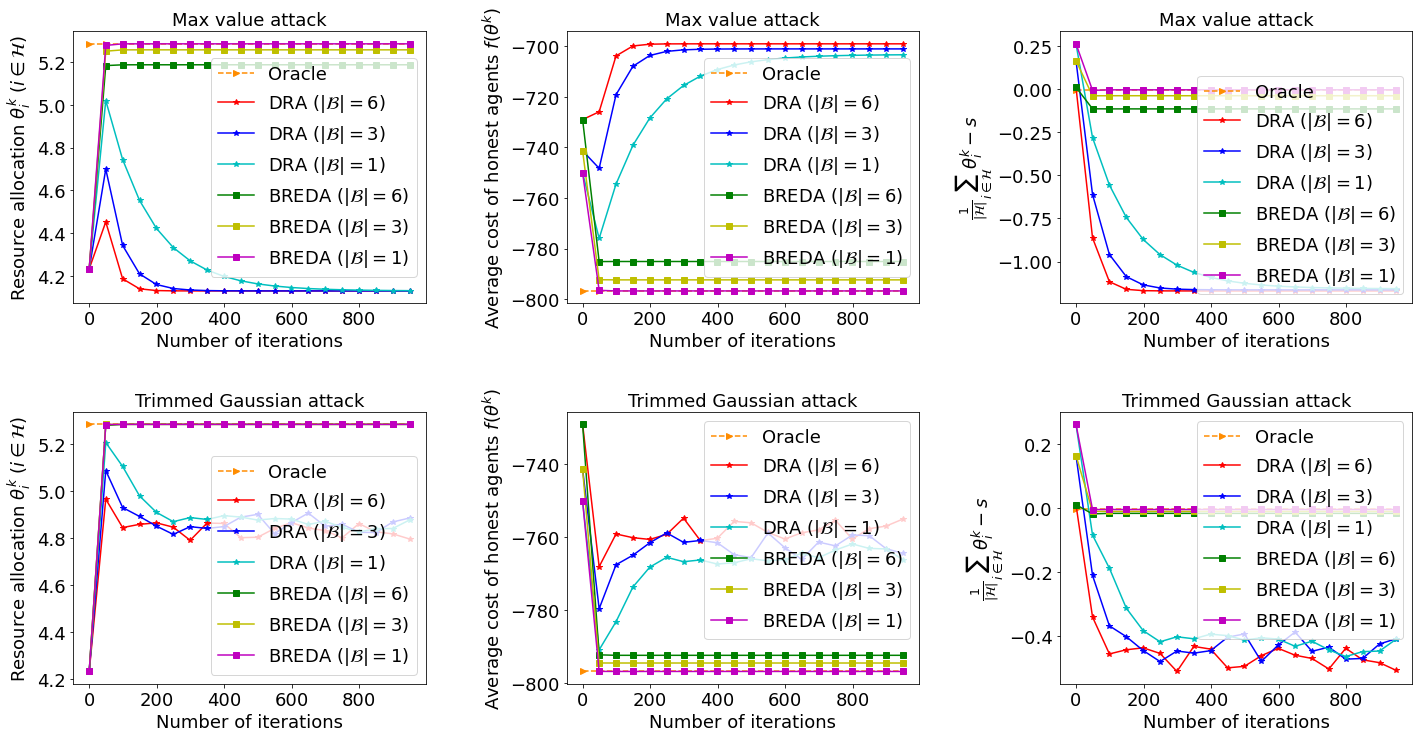

In [4]:
plt.subplot(2, 3, 1)##############################################################

iteration=[]
iteration.append(0)
for i in range(0,1000):
    iteration.append(i)

agent_resource_quantity_space=[]
for i in range (0,20):
    agent_resource_quantity_space.append(agent_resource_quantity[28][999])
    

#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack1_6B[28][slice(1,1001,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack1_3B[28][slice(1,1001,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack1_1B[28][slice(1,1001,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust1_6B[28][slice(1,1001,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust1_3B[28][slice(1,1001,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust1_1B[28][slice(1,1001,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'Resource allocation $\theta_{i}^{k}$ $(i \in \mathcal{H})$',font2)
plt.title('Max value attack',font2) 
 



plt.subplot(2, 3, 2)#########################################################################

 
average_cost_space=[]
for i in range (0,20):
    average_cost_space.append(average_cost[999])

#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],average_cost_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack1_6B[slice(0,1000,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack1_3B[slice(0,1000,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack1_1B[slice(0,1000,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust1_6B[slice(0,1000,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust1_3B[slice(0,1000,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust1_1B[slice(0,1000,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'Average cost of honest agents $f(\theta^{k})$',font2)
plt.title('Max value attack',font2) 
 


plt.subplot(2, 3, 3)#########################################################################


average_resource_space=[]
for i in range(0,1000):
    average_resource_space.append(5)
    
average_cost_gap_space=[]
for i in range (0,20):
    average_cost_gap_space.append(average_resource_quantity_true[999]-5)
    
#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],average_cost_gap_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack1_6B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack1_3B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack1_1B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust1_6B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust1_3B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust1_1B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font1,loc=4)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)

 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'$\frac{1}{\left |  \mathcal{H}  \right | } \sum_{i \in \mathcal{H}} \theta_{i}^{k}-s$',font2)
plt.title('Max value attack',font2) 
 



plt.subplot(2, 3, 4)##############################################################################
 
agent_resource_quantity_space=[]
for i in range (0,20):
    agent_resource_quantity_space.append(agent_resource_quantity[28][999])

#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack2_6B[28][slice(1,1001,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack2_3B[28][slice(1,1001,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_attack2_1B[28][slice(1,1001,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust2_6B[28][slice(1,1001,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust2_3B[28][slice(1,1001,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],agent_resource_quantity_robust2_1B[28][slice(1,1001,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}

font3 = {
'size'   : 18,
}

legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font3,loc=4)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)

 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'Resource allocation $\theta_{i}^{k}$ $(i \in \mathcal{H})$',font2)
plt.title('Trimmed Gaussian attack',font2) 
 


plt.subplot(2, 3, 5)##################################################################################

 
average_cost_space=[]
for i in range (0,20):
    average_cost_space.append(average_cost[999])

#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],average_cost_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack2_6B[slice(0,1000,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack2_3B[slice(0,1000,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_attack2_1B[slice(0,1000,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust2_6B[slice(0,1000,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust2_3B[slice(0,1000,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],average_cost_honest_robust2_1B[slice(0,1000,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}

font3 = {
'size'   : 18,
}

legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font3,loc=1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)

 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'Average cost of honest agents $f(\theta^{k})$',font2)
plt.title('Trimmed Gaussian attack',font2) 
 


plt.subplot(2, 3, 6)###############################################################################

average_resource_space=[]
for i in range(0,1000):
    average_resource_space.append(5)
    
average_cost_gap_space=[]
for i in range (0,20):
    average_cost_gap_space.append(average_resource_quantity_true[999]-5)
    
#在同一幅图片上画7条折线
A,=plt.plot(iteration[slice(0,1000,50)],average_cost_gap_space,marker = '>',color = 'darkorange',linewidth = '1.5',linestyle = '--',label='Oracle')
B,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack2_6B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'r',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=6$)')
C,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack2_3B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'b',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=3$)')
D,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_attack2_1B, average_resource_space)))[slice(0,1000,50)],marker = '*',color = 'c',linewidth = '1.5',label=r'DRA ($\left | \mathcal{B}  \right |=1$)')
E,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust2_6B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'g',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=6$)')
F,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust2_3B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'y',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=3$)')
G,=plt.plot(iteration[slice(0,1000,50)],list(map(lambda x: x[0]-x[1], zip(average_honest_resource_quantity_robust2_1B, average_resource_space)))[slice(0,1000,50)],marker = 's',color = 'm',linewidth = '1.5',label=r'BREDA ($\left | \mathcal{B}  \right |=1$)')

#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}

font3 = {
'size'   : 18,
}


legend = plt.legend(handles=[A,B,C,D,E,F,G],prop=font3)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('Number of iterations',font2)
plt.ylabel(r'$\frac{1}{\left |  \mathcal{H}  \right | } \sum_{i \in \mathcal{H}} \theta_{i}^{k}-s$',font2)
plt.title('Trimmed Gaussian attack',font2) 
 
 
    
#将文件保存至文件中并且画出图

plt.gcf().set_size_inches((24, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)


plt.savefig('./figures/figure3.pdf',format='pdf', bbox_inches='tight')

